# CO2 concentration in the atmosphere since 1958
blabla description of work + goals
- - -

First we run a Bash script that will check if the dataset is already in the folder. If it isn't, it gets dowloaded from [here](http://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record).
Because the data is updated regurlarly, we add a timestamp in the file name to keep track of which version of the dataset we are working with.

In [3]:
%%bash

if [ ! -f weekly_in_situ_co2_mlo* ]; then
	echo "I can't find the dataset, I'm gonna download it!"
	wget "http://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv" -O "weekly_in_situ_co2_mlo_$(date --rfc-3339 seconds).csv"
else
	echo "Dataset is already there, yay!"
fi

Dataset is already there, yay!


We then list the files in the folder and check the one with the expected suffix to get the actual file name.

In [4]:
import os

filename = next(x for x in os.listdir() if "weekly_in_situ_co2_mlo" in x)
print(filename)

weekly_in_situ_co2_mlo_2018-09-12 08:52:46+02:00.csv


Lets us take a look at this file.

In [5]:
%%bash
head -n 50 weekly_in_situ_co2_mlo*

"-------------------------------------------------------------------------------------------"
" Atmospheric CO2 concentrations (ppm) derived from in situ air measurements                "
" at Mauna Loa, Observatory, Hawaii: Latitude 19.5°N Longitude 155.6°W Elevation 3397m      "
"                                                                                           "
" Source: R. F. Keeling, S. J. Walker, S. C. Piper and A. F. Bollenbacher                   "
" Scripps CO2 Program ( http://scrippsco2.ucsd.edu )                                        "
" Scripps Institution of Oceanography (SIO)                                                 "
" University of California                                                                  "
" La Jolla, California USA 92093-0244                                                       "
"                                                                                           "
" Status of data and correspondence:                        

Now, we can import it as a Pandas dataframe. We know where the actual data start, and what the meaning of the different columns are. We can print the head of our dataframe to check we got things right.

In [6]:
import pandas as pd
import numpy as np
data = pd.read_csv(filename, header=43, names=['Date', 'Concentration'], parse_dates=[0])
print(data.head())

        Date  Concentration
0 1958-03-29         316.19
1 1958-04-05         317.31
2 1958-04-12         317.69
3 1958-04-19         317.58
4 1958-04-26         316.48


The date format is not very convenient for plotting, so we will convert it to float using a simple approximate computation.

In [7]:
dataYear = data['Date'].apply(lambda x: (float(x.strftime("%j")) - 1) / 366 + float(x.strftime("%Y")))
print(dataYear.head())

0    1958.237705
1    1958.256831
2    1958.275956
3    1958.295082
4    1958.314208
Name: Date, dtype: float64


Now, we can actually plot our dataset. Matplotlib will do it just fine for us. We add some fancy tweaks, and we get a nice chart.

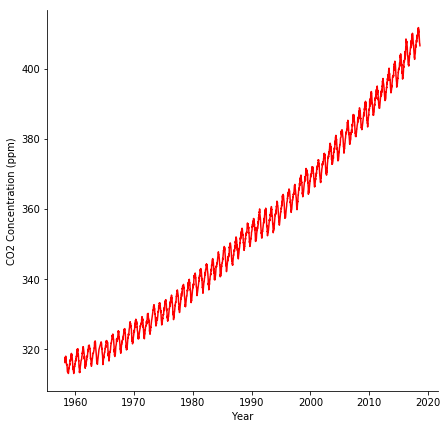

In [43]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(1, 1, figsize=[7, 7])
ax.plot(dataYear, data['Concentration'], c='r')
ax.set_xlabel("Year")
ax.set_ylabel("CO2 Concentration (ppm)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

We conjecture that this evolution is twofolds:
    - a periodic oscillation (with, approximately, a 1 year period)
    - a slower evolution
    
We first use a high-pass filter to try to isolate the periodic oscillation (of greater frequency).

We first print the Fast Fourier Transform of the evolution.

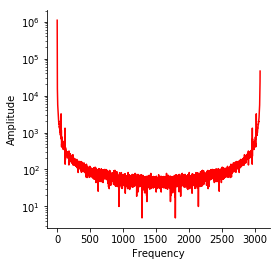

In [71]:
import scipy.signal # SIgnal Processing Library
array = data['Concentration']
array_fft = np.fft.fft(array) # getting the Fast Fourier Transform

f, ax1 = plt.subplots(1, 1, figsize=[4, 4])
ax1.plot(np.abs(array_fft), c='r')
ax1.set_xlabel("Frequency")
ax1.set_ylabel("Amplitude")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.semilogy()
plt.show()

The signals seems too noisy to figure out a frequency corresponding to the periodic oscillation.
The linear component could be the reason for this.

We then notice that the highs and lows of each year seem to happen always at the same time of the year.
TODO: verify that




/home/aurele/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


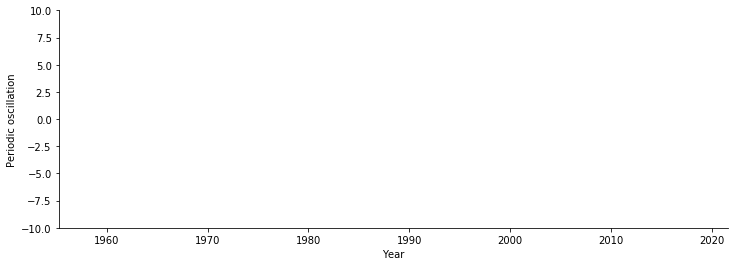

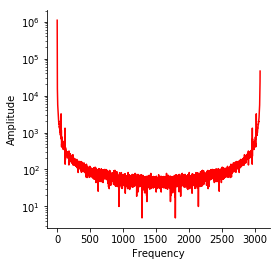

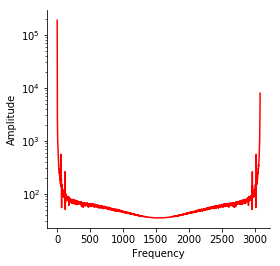

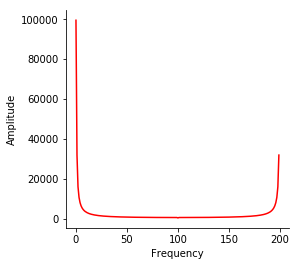

In [70]:
import scipy.signal # Signal Processing Library

order = 2
cutoff = 1 / (100 * 24 * 3600)
fs = 1 / (7 * 24 * 3600)

b, a = scipy.signal.butter(order, cutoff / (fs * 0.5), btype='low', analog=False)

array = data['Concentration']
array_fft = np.fft.fft(array) # getting the Fast Fourier Transform
a = 0.85
result = scipy.signal.lfilter(b, a, array)
result_fft = np.fft.fft(result)

f, ax0 = plt.subplots(1, 1, figsize=[12, 4])
ax0.plot(dataYear, result, c='r')
ax0.set_xlabel("Year")
ax0.set_ylabel("Periodic oscillation")
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.set_ylim([-10,10])
plt.show()


f, ax1 = plt.subplots(1, 1, figsize=[4, 4])
ax1.plot(np.abs(array_fft), c='r')
#ax1.set_xlim([0, 1500])
ax1.set_xlabel("Frequency")
ax1.set_ylabel("Amplitude")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.semilogy()
plt.show()

f, ax2 = plt.subplots(1, 1, figsize=[4, 4])
ax2.plot(np.abs(result_fft), c='r')
#ax2.set_xlim([0, 1])
ax2.set_xlabel("Frequency")
ax2.set_ylabel("Amplitude")
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.semilogy()
plt.show()

i = np.arange(0,1000,5)
cos = np.cos(2 * np.pi * i * 0.5) + i
#print (i,cos)
cos_fft = np.fft.fft(cos)
f, ax3 = plt.subplots(1, 1, figsize=[4, 4])
ax3.plot(np.abs(cos_fft), c='r')
#ax2.set_xlim([0, 1])
ax3.set_xlabel("Frequency")
ax3.set_ylabel("Amplitude")
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
# ax3.semilogy()
plt.show()
